# Sales Forecasting 
The aim of this project is to gain insights from the sales data and to forecast sales using time series analysis and a regression model.

======================================================================================================

# Data Exploration & Preprocessing
======================================================================================================

# Import libraries

In [1]:
# Basic libraries for handling/exploring data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# To check distribution of target variable
from scipy.stats import skew, kurtosis
from statistics import mode

# To encode categorical featuers
from feature_engine.encoding import CountFrequencyEncoder, OneHotEncoder

# To check for stationarity
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# for plotting missing values
import missingno as msno

# For exporting
import pickle

In [2]:
# Set custom palette
colors = ['#0F7173', '#885A89', '#6A381F', '#FCBF49', '#F3DFA2',  '#96E072']
sns.set_palette(sns.color_palette(colors))

# Load the Sales data

In [3]:
# Data available on Kaggle
# https://www.kaggle.com/c/rossmann-store-sales

dtypes = {'Store': int,
          'DayOfWeek':int,
          'Date':str,
          'Sales':int,
          'Customers':int,
          'Open':int,
          'Promo':int,
          'StateHoliday':str,
          'SchoolHoliday':int,
}

raw_data = pd.read_csv('train.csv', dtype=dtypes, index_col='Date', parse_dates=True)

In [4]:
data = raw_data.sort_values(['Date'],ascending = False)

# split the last 6 weeks (6*7) for the 1115 stores
split_index = 6*7*1115
train = data[split_index:]
validation = data[:split_index] 

In [5]:
train.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-06-19,741,5,7329,938,1,1,0,0
2015-06-19,747,5,9367,783,1,1,0,0
2015-06-19,746,5,7856,576,1,1,0,0


In [6]:
validation.tail(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-06-20,370,6,7654,653,1,0,0,0
2015-06-20,369,6,6805,648,1,0,0,0
2015-06-20,373,6,5123,367,1,0,0,0


In [7]:
validation.to_csv('validation.csv')

### Data fields
#### Target 
* **Sales:** the revenu for a given day -target value

##### ID feature
* **Store:** a unique numerical Id for each store

##### Date related features
* **DayOfWeek:** day of the week (from 1 to 7)
* **Date:** yyyy-mm-dd

##### Dummy  features
* **Open:** dummy for whether the store was open (1) or closed (0)
* **Promo:**  indicates whether a store is running a promo on that day (1)
* **SchoolHoliday:** indicates if the store/date was affected by the closure of public schools (1)

##### Categorical features
* **StateHoliday:** indicates a state holiday, where normally stores close. 0 = None, a = public holiday, b = Easter holiday, c = Christmas

##### Continuous features
* **Customers:** number of customers on a given day



# Exploratory Data Analysis

In [8]:
df = train.copy()

## Quick look 

In [9]:
# Checking for null and verifying data-types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 970379 entries, 2015-06-19 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store          970379 non-null  int32 
 1   DayOfWeek      970379 non-null  int32 
 2   Sales          970379 non-null  int32 
 3   Customers      970379 non-null  int32 
 4   Open           970379 non-null  int32 
 5   Promo          970379 non-null  int32 
 6   StateHoliday   970379 non-null  object
 7   SchoolHoliday  970379 non-null  int32 
dtypes: int32(7), object(1)
memory usage: 40.7+ MB


In [10]:
# Checking for encoded categorical variables and their cardinality, discrete variables and continuous variables 
df.nunique()

Store             1115
DayOfWeek            7
Sales            21585
Customers         4073
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64

In [11]:
# Exploring days without sales
df_no_sales = df[(df.Sales == 0) | (df.Open == 0)]
print('Percentage of data without sales: {:.2%}'.format(df_no_sales.shape[0] / df.shape[0] ))
df_no_sales.head()

Percentage of data without sales: 17.14%


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-06-19,183,5,0,0,0,1,0,0
2015-06-18,183,4,0,0,0,1,0,0
2015-06-17,183,3,0,0,0,1,0,0
2015-06-16,183,2,0,0,0,1,0,0
2015-06-15,183,1,0,0,0,1,0,0


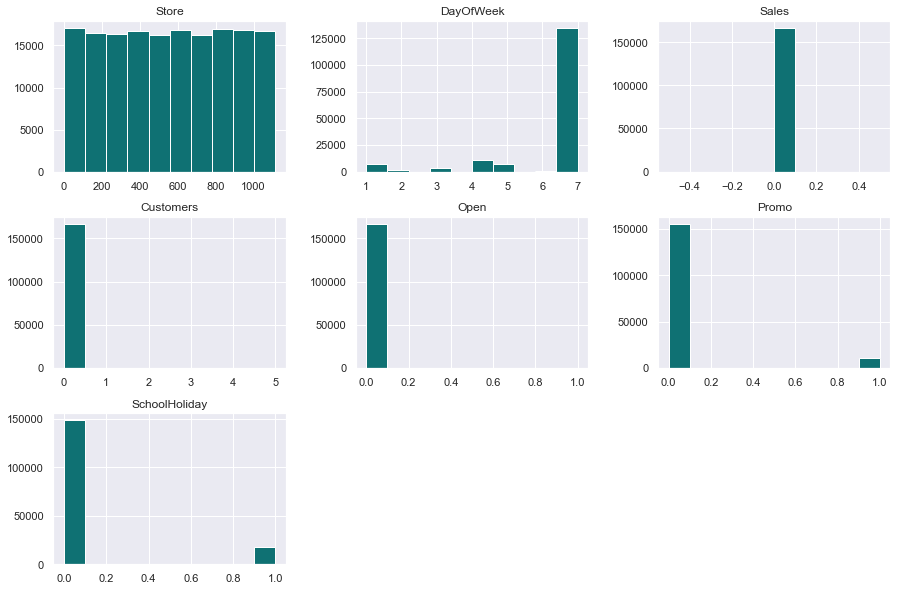

In [12]:
df_no_sales.hist(figsize=(15,10))
plt.show()

In [13]:
df_no_sales.Sales.value_counts()

0    166323
Name: Sales, dtype: int64

In [14]:
df_no_sales.Customers.value_counts()

0    166321
3         1
5         1
Name: Customers, dtype: int64

In [15]:
df_no_sales.Open.value_counts()

0    166269
1        54
Name: Open, dtype: int64

* Most of the time, stores seem to be closed on Sundays, which make sense
* Surprisingly, it would seem that on days without sales there were customers, so one can imagine that either they did not purchase anything, they were doing an exchange, or it is an error
* For 54 days at least some of the stores were opened but did not make any sales, probably because of some external event

This data do not seem to add to our analysis. Moreover, for days where the store is closed one can simply predict that sales will be 0 without need of any modelling. Samewise, for those days when the store was opened and there was no sales, it would be probably linked to some external event we cannot account in our future forecasting.

Therefore, it is better to exclude this data.

In [16]:
# Excluding all data where there were no sales or the store was closed
df = df[df.Sales > 0]

# Checking "Open" feature
df.Open.value_counts()

1    804056
Name: Open, dtype: int64

In [17]:
# Now "Open" can be safely removed
df = df.drop(['Open'], axis=1)

# Target Variable

In [18]:
df.Sales.describe()

count    804056.000000
mean       6954.822954
std        3106.252581
min          46.000000
25%        4856.000000
50%        6368.000000
75%        8360.000000
max       38722.000000
Name: Sales, dtype: float64

## Distribution

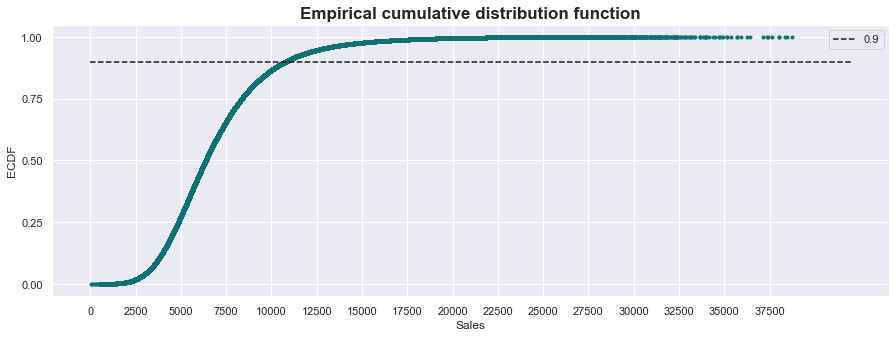

In [19]:
# Plotting the ECDF
x = np.sort(df['Sales'])
y = np.arange(1,len(df)+1)/len(df)

plt.figure(figsize=(15,5))
plt.plot(x, y, marker='.', linestyle='none');
plt.xlabel('Sales')
plt.ylabel('ECDF')
plt.yticks(np.arange(0,1.1,0.25))
plt.xticks(np.arange(0, max(df.Sales), 2500))
plt.title('Empirical cumulative distribution function', weight='bold', size=17)
plt.hlines(y=0.9, xmin=0,  xmax=42000,  linestyles='--', color='k', label='0.9')
plt.legend()
plt.show()

In [20]:
def vis_distribution(df = df, var = str, transf = str):
    '''
    It first gets the (transformed) data, 
    then compute central tendencies (CT) in a dictionary, 
    plots distribution, add CTs and print Skewness/Kurtosis.
    '''
    
    # Getting the data
    if transf == 'log':
        data = np.log(df[f'{var}'])
    elif transf == 'sqrt':
        data = np.sqrt(df[f'{var}'])
    else:
        data = df[f'{var}']
        
    # Getting mode, median & mean
    central_tendencies = {}
    central_tendencies['mode'] = data.mode()[0]
    central_tendencies['median'] = data.median()
    central_tendencies['mean'] = data.mean()
    
    
    # Distribution plot
    sns.displot(data = data, kde = True, aspect = 2, color = colors[0])
    
    # Plotting central tendencies
    for i, (name, value) in enumerate(central_tendencies.items()):
        plt.axvline(x=value,
                    ymin=0, ymax=2500, 
                    label=f'{name}', ls='--', lw = 2.5,
                    color=colors[i+1])
        
    # Title, ticks & legend
    try:
        transf = transf.capitalize()
    except TypeError:
        transf = ''
    
    plt.title(f'{transf} {var.capitalize()} Distribution ', 
              weight='bold', size=17)
    plt.legend()
    plt.show()
    
    print('Skewness:', skew(data))
    print('Kurtosis:', kurtosis(data))

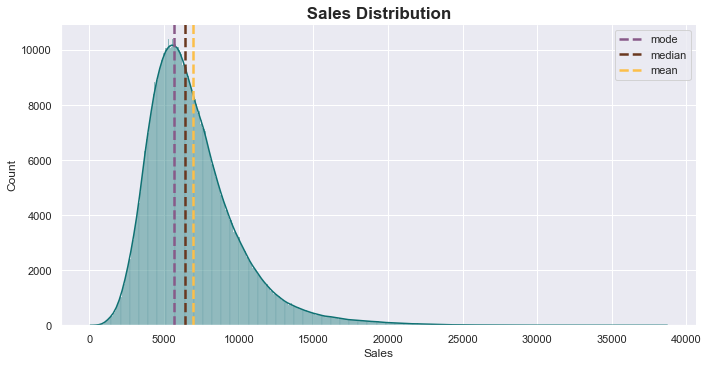

Skewness: 1.5943053276610764
Kurtosis: 4.842030980800279


In [21]:
vis_distribution(var='Sales')

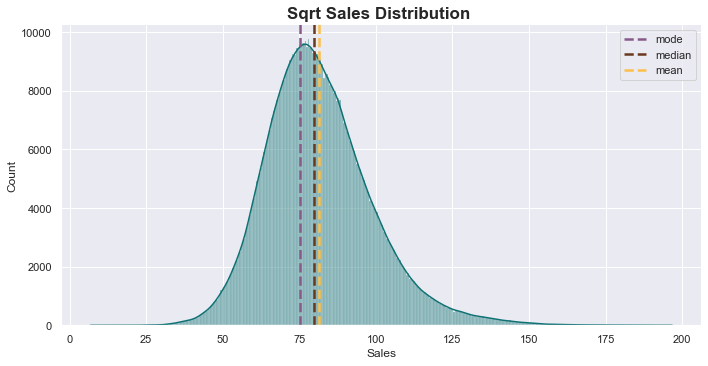

Skewness: 0.7008517750394596
Kurtosis: 1.267205041979973


In [22]:
vis_distribution(var='Sales', transf='sqrt')

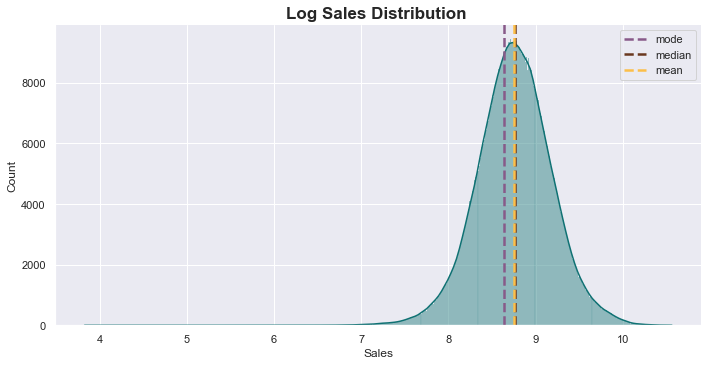

Skewness: -0.11038473967652895
Kurtosis: 0.6545433583660785


In [23]:
vis_distribution(var='Sales', transf='log')

Both the squared- and the log-transformation seem to improve the spread of the target variable. 

The log transformation seem to be slightly better as it has lower Skewness (which can also be seen by the fact that the mean and median are closer to each other).

We can observe from the ECDF that 90% of sales are below 11,000.

# Features

## StateHoliday

**StateHoliday:** indicates a state holiday, where normally stores close. 0 = None, a = public holiday, b = Easter holiday, c = Christmas

In [24]:
df.StateHoliday.value_counts()

0    803146
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

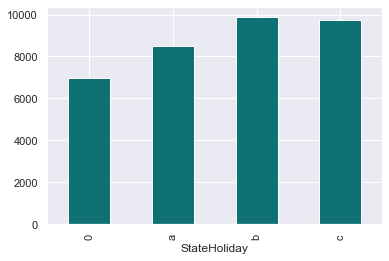

In [25]:
df.groupby('StateHoliday')['Sales'].mean().plot(kind = 'bar')
plt.show()

As one would imagine, most days are not holidays, and most holidays are public holidays. 

Moreover, when the holiday is related to either Christmas or Easter, sales seem to be higher than for a public holiday or when there are no holidays at all.

As Christmas and Easter are relative rare labels and have a similar relation with Sales, they could be regrouped, such as:
* 0: None
* 1: Public holiday
* 2: Easter or Christmas

In [26]:
holiday_dict = {'0':0, 'a':1, 'b':2, 'c':2}

df.StateHoliday = df.StateHoliday.replace(holiday_dict)
df.StateHoliday.value_counts()

0    803146
1       694
2       216
Name: StateHoliday, dtype: int64

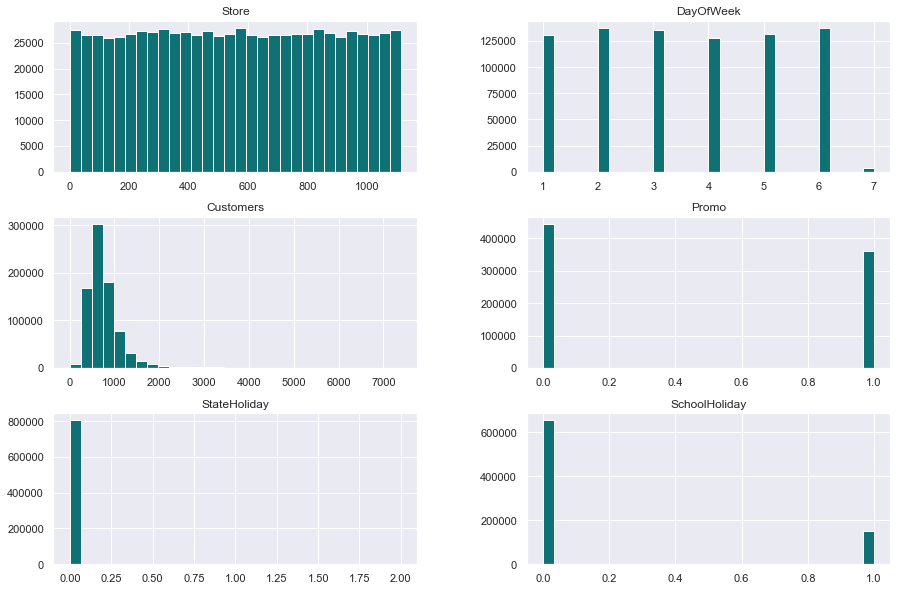

In [27]:
df.drop('Sales', axis = 1).hist(figsize = (15,10), bins = 30)
plt.show()

### Apply log transformation to skewed variable

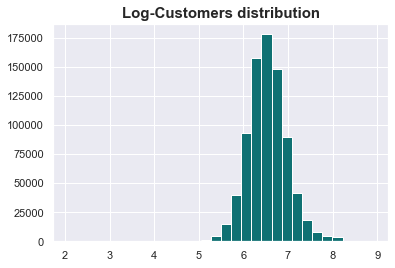

In [28]:
np.log(df.Customers).hist(bins = 30)
plt.title('Log-Customers distribution', weight = 'bold', size = 15)
plt.show()

In [29]:
df.Customers = np.log(df.Customers)

"Customers" seem to have a better spread after being log-transformed. This could help with the forecasting.

## Sales time-series

### Exploring Years, Months, Weeks, and Days

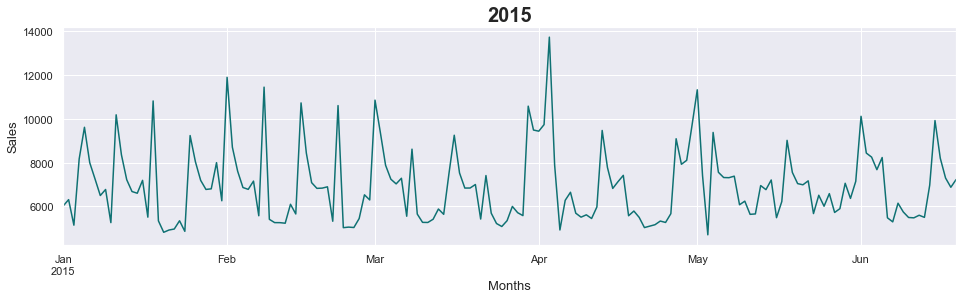

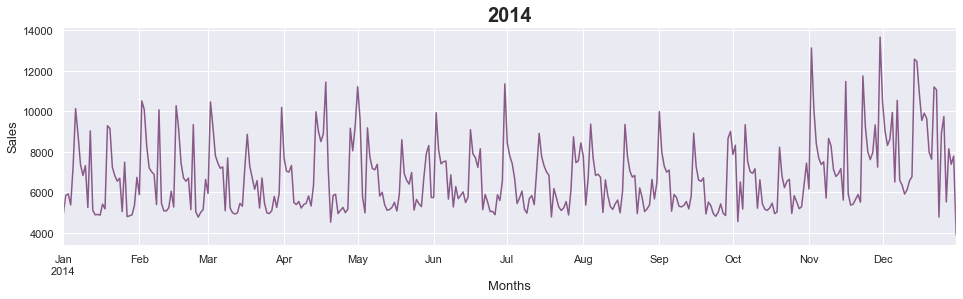

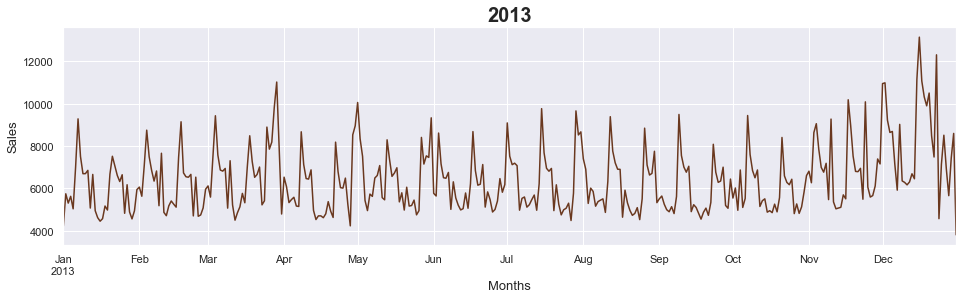

In [30]:
# Plot median sales by year
years = list(df.index.year.unique())

for i, year in enumerate(years):
    plt.figure(figsize = (16,4))
    df.loc[f'{year}'].groupby('Date')['Sales'].median().plot(color=colors[i])
    plt.title(f'{year}', weight='bold', size=20)
    plt.xlabel('Months', size = 13)
    plt.ylabel('Sales', size = 13)
    plt.show()

### Extract dates

In [31]:
def extract_and_show_date(date = str, i = 0):
    date = date.lower().capitalize()
    
    # Create new feature
    if date == 'Year':
        df[f'{date}'] = df.index.year
    elif date == 'Month':
        df[f'{date}'] = df.index.month
    elif date == 'Week':
        df[f'{date}'] = df.index.isocalendar().week
    elif date == 'Day':
        df[f'{date}'] = df.index.day
    
    # Plot distribution
    plt.figure(figsize = (15,5))
    df.groupby(f'{date}')['Sales'].mean().plot.bar(color = colors[i])
    plt.title(f'Average number of Sales by {date}', weight='bold', size=15)
    plt.xticks(rotation=0)
    plt.ylabel('Sales')
    plt.xlabel(f'{date}')
    plt.show()
    
    # Computing correlation
    corr = df[f'{date}'].astype('float64').corr(df.Sales)
    print(f'{date} correlation with Sales', round(corr, 3))

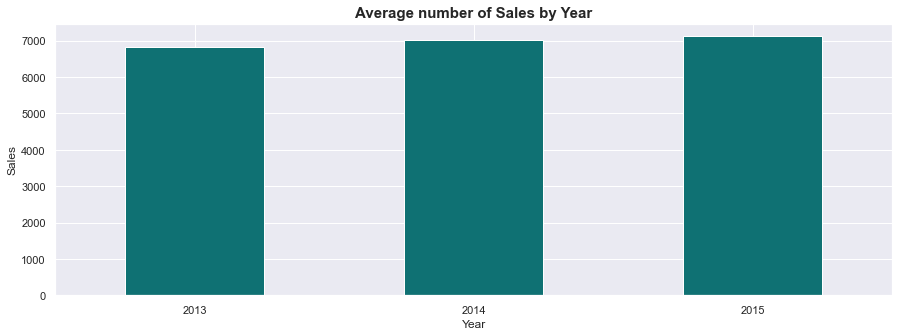

Year correlation with Sales 0.039



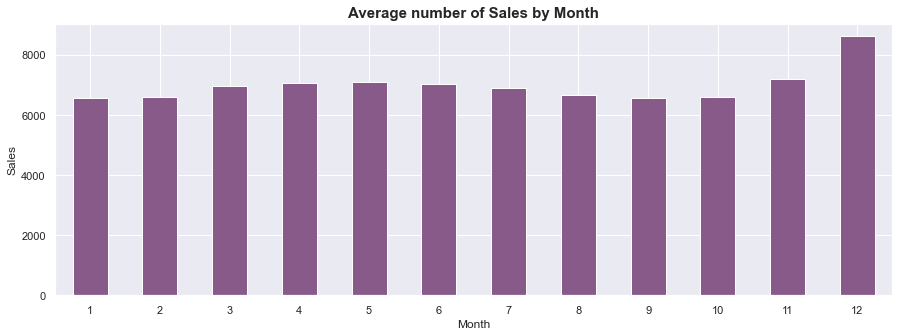

Month correlation with Sales 0.075



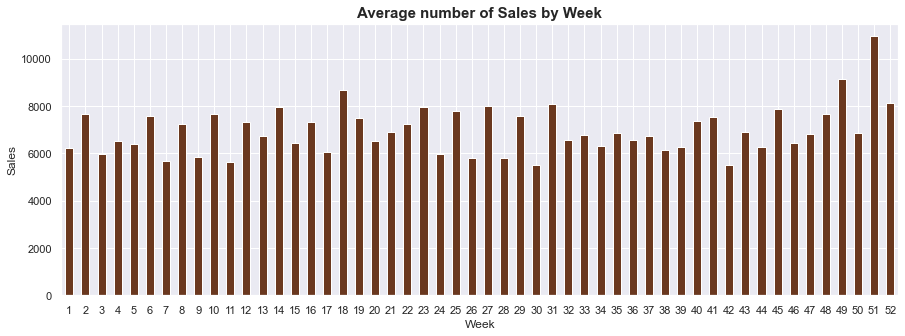

Week correlation with Sales 0.076



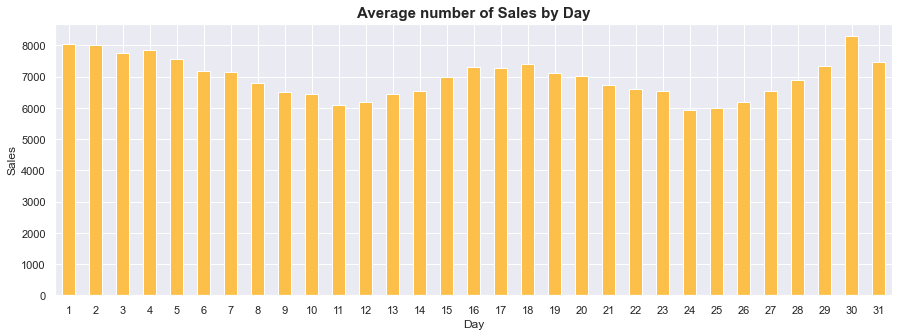

Day correlation with Sales -0.059



In [32]:
dates = ['year', 'month', 'week', 'day']

for i, date in enumerate(dates):
    extract_and_show_date(date = date, i = i)
    print()

#### Day of the Week

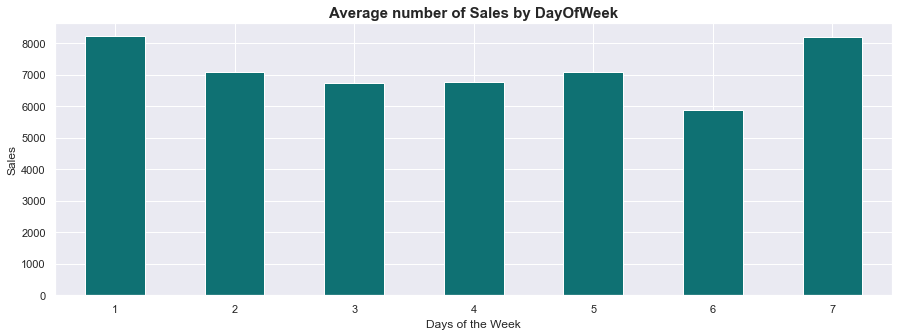

Day correlation with Sales -0.177


In [33]:
# Exploring relationship between different DayOfWeek and Sales
plt.figure(figsize=(15,5))
df.groupby('DayOfWeek')['Sales'].mean().plot(kind='bar')
plt.title('Average number of Sales by DayOfWeek', weight='bold', size=15)
plt.xticks(rotation=0)
plt.ylabel('Sales')
plt.xlabel('Days of the Week')
plt.show()

# Computing correlation
corr = df.DayOfWeek.corr(df.Sales)
print('Day correlation with Sales', round(corr, 3))

In [34]:
df.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day
Date,,,,,,,,,,,
2015-06-19,741,5,7329,6.843750,1,0,0,2015,6,25,19
2015-06-19,747,5,9367,6.663133,1,0,0,2015,6,25,19
2015-06-19,746,5,7856,6.356108,1,0,0,2015,6,25,19
2015-06-19,745,5,8074,6.612041,1,0,0,2015,6,25,19
2015-06-19,744,5,8626,6.816736,1,0,0,2015,6,25,19


## Checking stationarity
**Stationarity** is an important assumption in time series analysis/forecasting, as it means that the statistical properties do not change over time, i.e. *"the mean, variance and autocorrelation structure do not change over time."*.
source: [NIST/SEMATECH e-Handbook of Statistical Methods](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm)



In [35]:
for year in years:
    mean = df.loc[f'{year}','Sales'].mean()
    std = df.loc[f'{year}','Sales'].std()
    
    print(f'{year} ==> ', 'mean:', round(mean,2), 'std:',round(std,2))

2015 ==>  mean: 7116.58 std: 3028.15
2014 ==>  mean: 7026.13 std: 3128.6
2013 ==>  mean: 6814.78 std: 3115.34


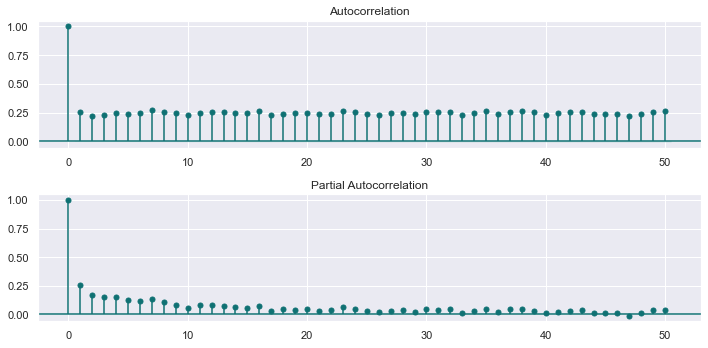

Wall time: 1min 50s


In [36]:
%%time
# Checking autocorrelation & Partial autocorrelation
fig,ax= plt.subplots(2,1, figsize=(10,5), tight_layout = True)
fig=plot_acf(df.Sales, lags=50, ax=ax[0])
fig=plot_pacf(df.Sales, lags=50, ax=ax[1])
plt.show()

It would seem that the data is **stationary**, as the mean and variance are roughly the same across the 3 periods, and the autocorrelation do not seem to change greatly over time.

We can confirm this by applying an **Augmented Dickey Fuller Test (ADF):**

In [37]:
# %%time
# result = adfuller(df.loc['2015']['Sales'])
# print(f'used lags: {result[2]}')

In [38]:
%%time
# For the whole data, if maxlag = None => MemoryError
# Thus, I use the maxlag found for the 2015 sales, when maxlag = None (as the data is smaller "None" does not lead to errors)

result = adfuller(df.Sales, maxlag=80)

Wall time: 5min 32s


In [39]:
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}.3f' )

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -21.801069693765072
p-value: 0.0
Critical Values:
	1%: -3.4303581337365947.3f
	5%: -2.8615435950188335.3f
	10%: -2.5667719134966807.3f
Reject Ho - Time Series is Stationary


# Including Stores Data

In [41]:
stores = pd.read_csv('stores_data.csv', index_col='Store')
stores

,StoreType,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Assortment_basic,Assortment_extended,Assortment_extra,PromoInterval_0,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",StateGDP,StateDensity
Store,,,,,,,,,,,,,,,,
1,148,7.146772,9,2008,0,0,0,1,0,0,1,0,0,0,37509,287
2,602,6.345636,11,2007,1,13,2010,1,0,0,0,1,0,0,21663,138
3,602,9.556055,12,2006,1,14,2011,1,0,0,0,1,0,0,32882,523
4,148,6.429719,9,2009,0,0,0,0,1,0,1,0,0,0,28806,3890
5,602,10.305948,4,2015,0,0,0,1,0,0,1,0,0,0,22980,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,602,7.549609,6,2014,1,31,2013,1,0,0,0,1,0,0,32882,523
1112,148,7.539027,4,2006,0,0,0,0,1,0,1,0,0,0,32882,523
1113,602,9.133459,8,2010,0,0,0,0,1,0,1,0,0,0,25947,179


### Data fields
#### Features overview
* **Store:** a unique numerical Id for each store ("key" with sales data)
* **StoreType:** differentiates between 4 different store models (a, b, c, d)
* **Assortment :** describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance:** distance in meters to the nearest competitor store
* **CompetitionOpenSinceYear:** number of months since competition opened
* **Promo2:** it is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2SinceYear:**  describes the year when the store started participating in Promo2

In [42]:
df = df.join(stores, on='Store')

## Best vs Worst performing stores

In [43]:
# Finding best/worst performing stores
N_STORES = 50

last_stores = df.groupby('Store')['Sales'].mean().sort_values().head(N_STORES).index
top_stores = df.groupby('Store')['Sales'].mean().sort_values().tail(N_STORES).index

In [44]:
unwanted_cols = ['Store', 'Sales', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek','PromoInterval_0']
features_to_lookup = [col for col in df.columns if col not in unwanted_cols]

In [45]:
# Saving Mean/Std for best/worst stores in temporary dataframes "a" & "b"
a = df[df.Store.isin(last_stores)][features_to_lookup].agg(['mean', 'std'])
a = a.T

b = df[df.Store.isin(top_stores)][features_to_lookup].agg(['mean', 'std'])
b = b.T

In [46]:
# Joining temp dfs
df_top_last_stores_agg = a.join(b, lsuffix='_last_stores', rsuffix='_top_stores')

In [47]:
def analyze_stores(var):
    df_top_last_stores_agg.loc[[f'{var}']][['mean_last_stores', 'mean_top_stores']].plot.bar(figsize=(10,5))
    plt.axhline(y=df[f'{var}'].mean(), color='k', linestyle='--', label='total mean')
    plt.title(f'{var}', weight='bold', size=15)
    plt.ylabel(f'{var} frequency')
    plt.xticks([])
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

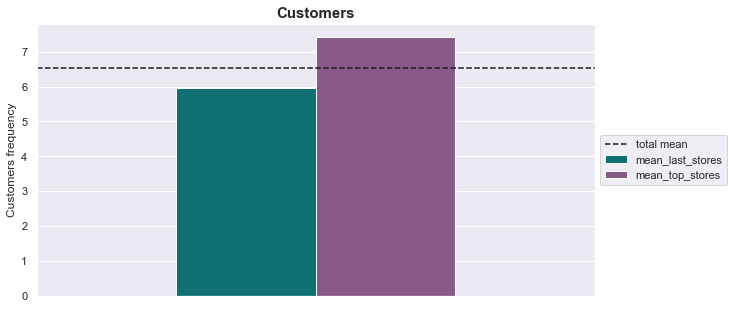

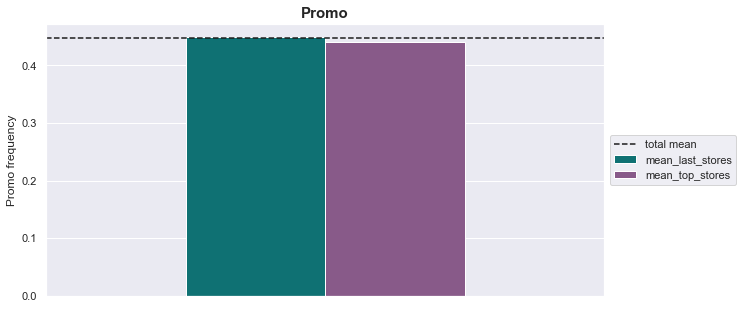

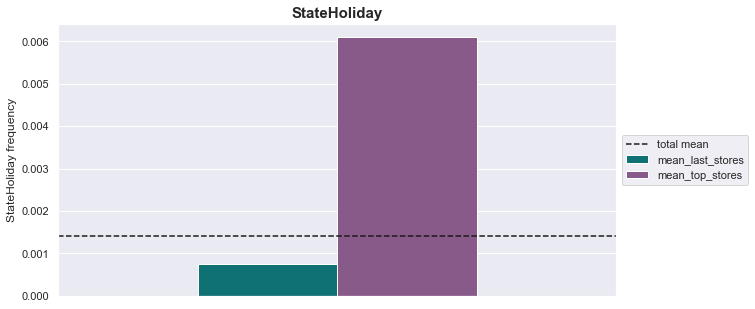

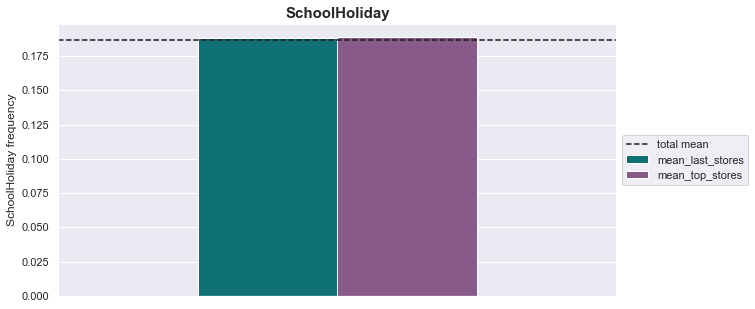

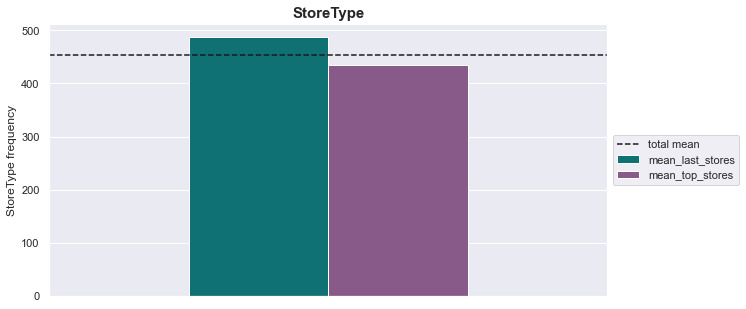

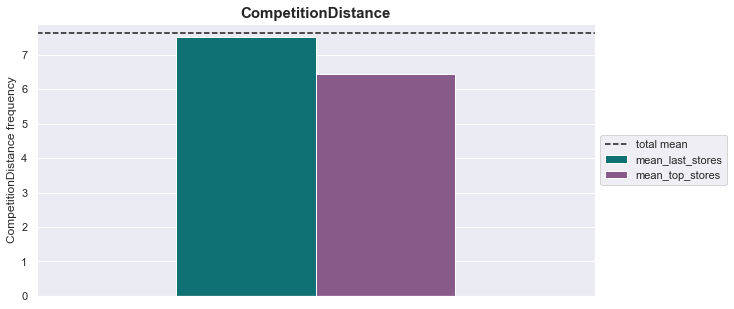

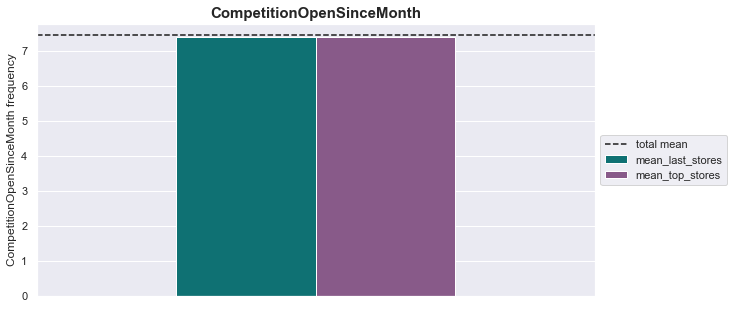

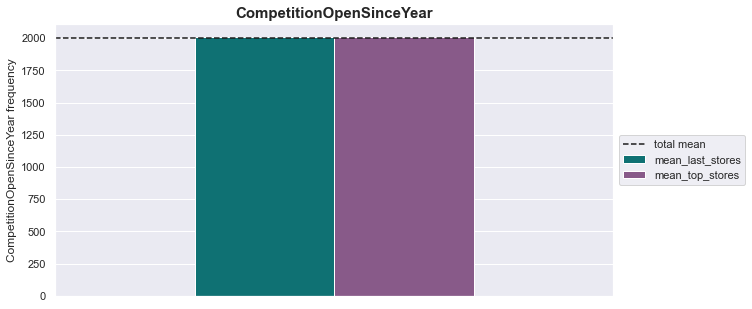

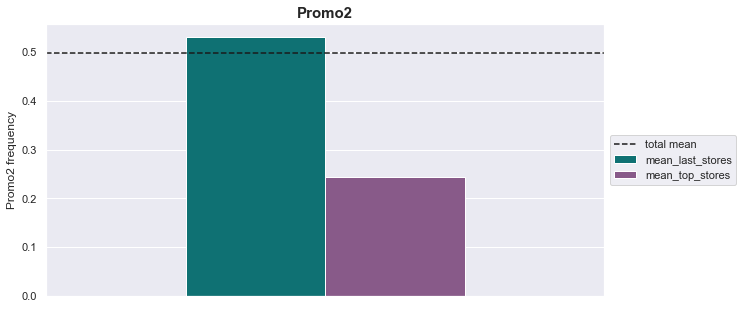

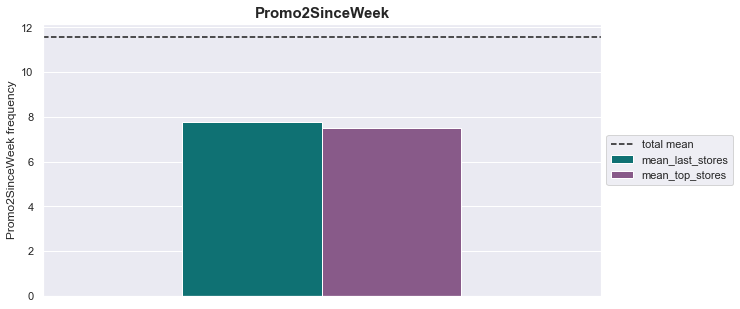

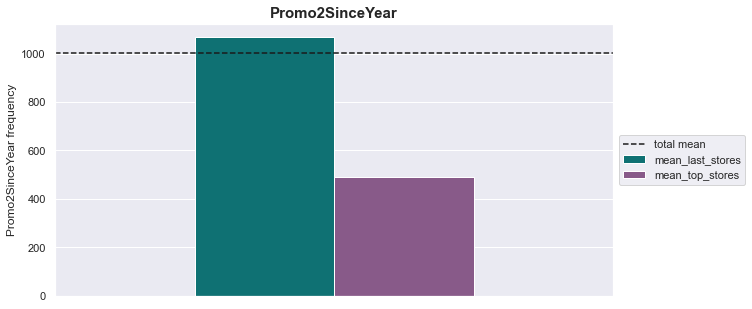

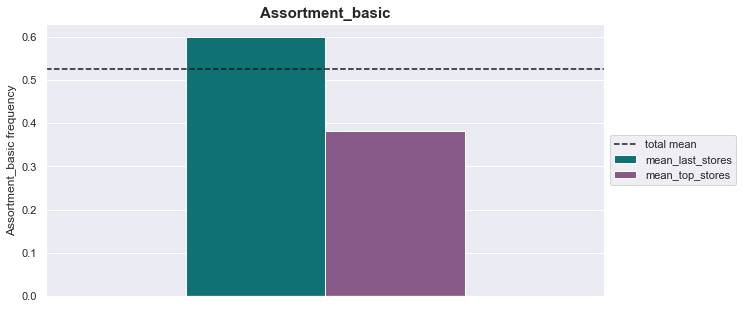

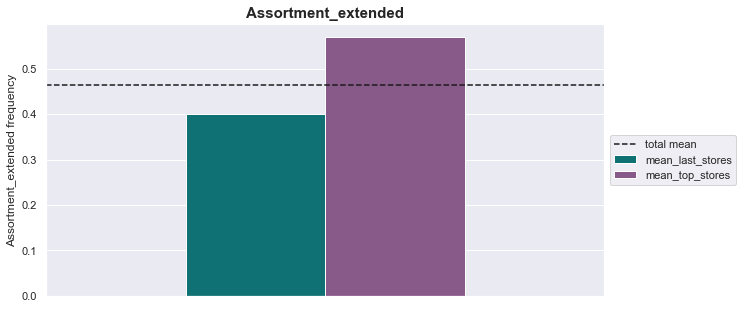

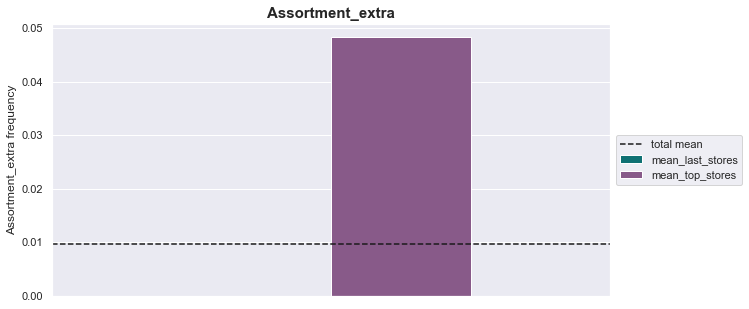

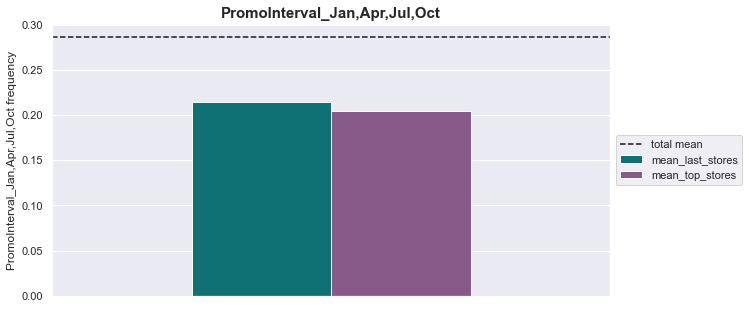

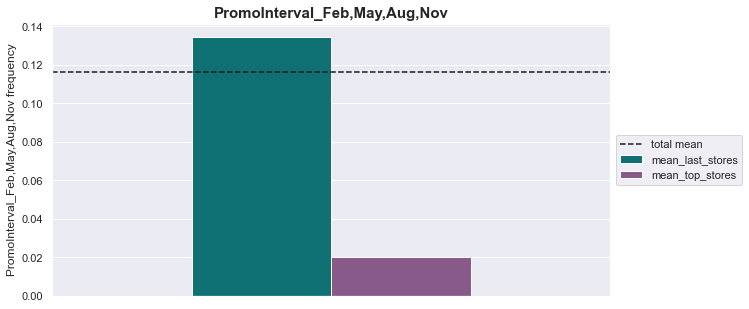

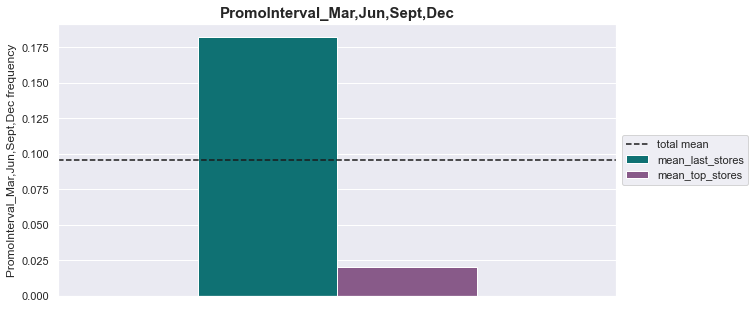

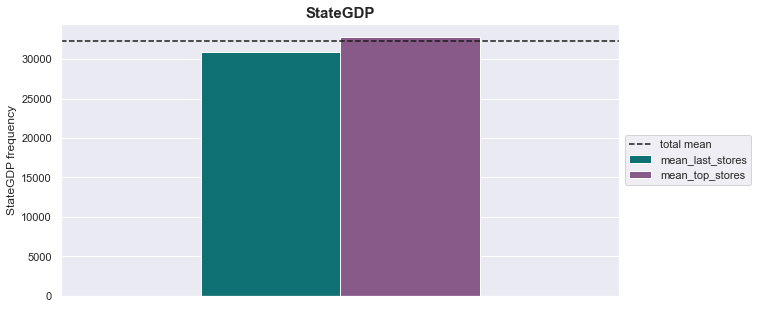

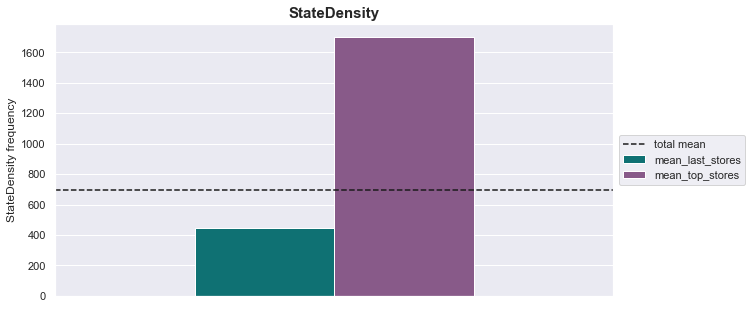

In [48]:
for var in df_top_last_stores_agg.index:
    analyze_stores(var)

##### Takeaways

1. As expected, stores with higher sales also have more customers.

2. The "promo" feature is as frequent in top and in last performing stores, this makes sense as promotion usually are available across stores of the same chain.

3. As one could expect, "SchoolHolidays" are as frequent in both type of stores. However, it seems that stores with the most sales have more "StateHolidays" than their counterpart.

4. There seem to be a difference in sales performance and the type of store.

5. The stores with the most sales appear to be relatively close to their competitors, which could mean that they are located in denser areas, with a higher number of potential customers and/or higher prices.

6. There does not seem to be a difference between the number of Months or the Year since competitors installed.

7. The second promotion seem to be much more present in stores with the lowest sales.

8. In general, stores with the lowest sales seem to be participating in the second promotion the longer.

9. The basic assortment is much more present in stores with lowest sales, while the "extended" and the "extra" assortment is more frequent in stores with higher sales.

10. Top Stores seem to be slightly more present in states with higher GDPs.

11. Top Stores seem to be located in very dense areas.

In [49]:
# Checking effect of "StoreType"
df.groupby('StoreType')['Sales'].mean()

StoreType
17     10205.712448
148     6935.461984
348     6814.412879
602     6928.162348
Name: Sales, dtype: float64

It would seem that the least frequent type of store is the one doing the more sales, while the others have roughly similar mean values.

## Customers
The Customers feature is available in the training and validation data, but in a real scenario, we cannot know how many customers there will be in the future. 

Therefore, we cannot keep the feature as it is.

In [50]:
dict_day_cust = df.groupby(['Week'])['Customers'].mean().to_dict()

filename = 'dict_day_cust.pkl'
pickle.dump(dict_day_cust, open(filename, 'wb'))

In [51]:
df['AvgWeaklyCusts'] = df.Week.replace(dict_day_cust)

print(f'AvgWeaklyCusts-Correlation with Sales prices: {round(df.AvgWeaklyCusts.corr(df.Sales), 3)}')

AvgWeaklyCusts-Correlation with Sales prices: 0.308


## Export train data

In [52]:
df.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,...,Assortment_basic,Assortment_extended,Assortment_extra,PromoInterval_0,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",StateGDP,StateDensity,AvgWeaklyCusts
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-19,741,5,7329,6.843750,1,0,0,2015,6,25,...,0,1,0,1,0,0,0,70755,1743,6.604942
2015-06-19,747,5,9367,6.663133,1,0,0,2015,6,25,...,0,1,0,1,0,0,0,22427,116,6.604942
2015-06-19,746,5,7856,6.356108,1,0,0,2015,6,25,...,0,1,0,0,0,0,1,37509,287,6.604942
2015-06-19,745,5,8074,6.612041,1,0,0,2015,6,25,...,1,0,0,0,1,0,0,22980,227,6.604942
2015-06-19,744,5,8626,6.816736,1,0,0,2015,6,25,...,1,0,0,0,1,0,0,35443,178,6.604942


In [53]:
# Before export we can remove the "Store" column which cannot help with forecasting sales for the ensemble of stores
df = df.drop(['Store'], axis = 1)
df.to_csv('sales_store_train_data.csv')